# Exercise 4: Image Classification

**Deadline: 23 December 2022, 11:59 PM**            

**Covered Topics: Lecture 9-10**


Given an input RGB image, you should train a neural network which outputs the class label the image belongs to.
There are six class labels in our dataset: "buildings", "forests", "mountains", "glacier", "sea", and "street".
In order to design and train your network, we provide a training set and validation set along with class labels for every image.
As you are already familiar, we separate the dataset into three splits: training, validation, and testing.
The train set has 6K images (1K per class), and the val and test sets each have 1.2K images (200 per class).

An overview of the desired pipeline is shown in Figure.


![](https://docs.google.com/drawings/d/e/2PACX-1vRynZcZ1jfCu1GAsY9Hww68kr3iGaHj5XKeQptkF9lRysFpMtbbs4TZZaklAemoZJbMR-LUQnVkkI0b/pub?w=680&h=483 "Title")


This exercise acts as a gentle introduction to [PyTorch](https://pytorch.org/), one of the most popular deep learning frameworks.
We provide a majority of the code to get you started and familiarized with the framework.
Running through all the cells will give you a simple linear network that can achieve the baseline performance.
To pass, you will need to modify the given implementation and train a network that can achieve better performance.

**Evaluation Criteria**

Your algorithm will be evaluated using classification accuracy, which is the proportion of images with the correct predicted label.
The final EvaluationScore is obtained as the classification accuracy over all test samples.

**Passing requirement**

Your algorithm will be evaluated on a test set. In order to pass the exercise, you need to obtain an EvaluationScore of **greater than $70.0$** on the test set.

Follow the steps in the rest of the notebook to generate the submission. The evaluation server for the exercise is at https://codalab.lisn.upsaclay.fr/competitions/8751.

## Initialize the environment and load data
Import the necessary libraries. Note that you are **NOT** allowed to use any additional libraries

In [10]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import csv
import cv2
import os
import numpy as np
import random
import shutil

import sys

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**TODO:** Set the path in Google drive where you uploaded the handout, e.g. My Drive/iacv/ex4



In [11]:
iacv_path = '.' # TODO set this

env_path = f'{iacv_path}'
# Add the handout folder to python paths
if env_path not in sys.path:
    sys.path.append(env_path)

Define the plotting function to visualize the images and the network predictions.

In [12]:
# class labels. This provides the mapping from the integer label for an image to
# a descriptive name
classes = ["Buildings", "Forest", "Mountains", "Glacier", "Sea", "Street"]

# function to show image
def show_images(ims, gt_labels, pred_labels=None):
    fig, ax = plt.subplots(1, len(ims), figsize=(20, 20))
    for id in range(len(ims)):
        im = ims[id]
        im = im / 2 + 0.5     # unnormalize
        im_np = im.numpy()

        ax[id].imshow(np.transpose(im_np, (1, 2, 0)))

        if pred_labels is None:
            im_title = f'GT: {classes[gt_labels[id]]}'
        else:
            im_title = f'GT: {classes[gt_labels[id]]}   Pred: {classes[pred_labels[id]]}'
        ax[id].set_title(im_title)
    plt.show()


## Overview

In general, training any deep learning models consists of the following components


*   **Dataset:** The data on which the model is trained. This could be e.g. large number of images, videos, text documents etc.
*   **Model:** The network architecture we want to train. A significant part of developing deep learning solutions involves designing right architecture for a given problem.
*   **Cost Function:** The criteria which is minimized over our dataaset to train the network, e.g. Cross-entropy loss, Mean-squared error.  
*   **Optimizer:** The optimizer updates the model parameters to minimize the cost function. The most common example is Stochastic Gradient Descent. One also has to determine hyperparameters such as the learning rate, number of optimization iterations etc. 

As discussed in the lectures, the deep networks are trained using *mini-batches*, which are a set of training images (commonly between 8-128). Furthermore, data augmentation strategies (e.g. rotating an image) are commonly used to 'transform' the training images first, before passing it to a network. Thus, the data loading step itself can be broken down into following sub-steps,
1.   Load an image from the dataset. The images are randomly loaded from the dataset during training to avoid any bias.
2.   Apply necessary pre-processing to the image, e.g. remove mean, convert datatype to `float` etc.
3.   Apply desired data augmentations to the image, e.g. rotate an image, extract a random crop from the image.
4. Group a number of processed images to form a 'training batch'. This batch is then passed through the network to obtain predictions and compute loss.




We will use the [PyTorch](https://pytorch.org/) deep learning framework to implement each of these components. Follow through the next cells to check the implementation.


## Step 1: Data Loading

We first take a look at how to define the datasets and data loading procedures in PyTorch.

To do so, we need to create a PyTorch Dataset and DataLoader.
The PyTorch Dataset handles loading the actual images and labels from file as well as applying any transformations on the loaded image. To define your own Dataset, you need to subclass the `torch.utils.data.Dataset` class and implement three functions:

1. `__init__`: Initialize the dataset.
2. `__len__`: Returns the number of samples in the dataset.
3. `__getitem__`: Given a specific index, load the corresponding image and labels, apply necessary transformations, and return them.

We have implemented a dataset class for our task here. Please take a close look at how it is done.

In [13]:
import csv
import h5py
from PIL import Image
from io import BytesIO

import torchvision
from torch.utils.data import Dataset, DataLoader


def load_image(hdf5_file, im_path):
    """Helper function for loading images stored in a HDF5 file.
    
    HDF5 enables a compact way to store images, without needing to store each
    image as a separate file.
    """
    return np.array(
        Image.open(BytesIO(bytearray(bytes(hdf5_file[im_path][()]))))
    )


class ImageDataset(Dataset):
    """PyTorch Dataset for loading our data.
    
    annotations_file specifies the file that stores the classification labels.
    img_file specifies the file where all images are stored.
    transform specifies the transformations to apply to the loaded image.
    """

    def __init__(self, annotations_file, img_file, transform=None):
        """Initialize dataset."""
        with open(annotations_file) as fp:
            self.img_labels = [line.strip().split(',') for line in fp.readlines()]
        self.img_file = h5py.File(img_file, mode="r")
        self.transform = transform

    def __len__(self):
        """Return length of dataset."""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Get image and labels at the given index."""
        image = load_image(self.img_file, self.img_labels[idx][0])
        if self.transform:
            image = self.transform(image)
        if len(self.img_labels[idx]) > 1:
            label = int(self.img_labels[idx][1])
            return image, label
        return image


Note that the PyTorch Dataset only deals with loading a single image at a time.
The data sampling logic for loading multiple images is handled by the PyTorch DataLoader, which takes the Dataset as input and defines the logic for how to iterate over the entire dataset. To create the DataLoader, you need to use `torch.utils.data.DataLoader`, which has the following arguments:

- `dataset`: A PyTorch Dataset.
- `batch_size`: Number of images to load at a time.
- `shuffle`: Whether to shuffle the dataset before loading the images. Usually, you will use shuffling during training and not during testing.
- `num_workers`: Number of subprocesses to use for data loading.
- ... and many more. You can find the full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).


The following function returns DataLoaders for each of our training, validation, and test datasets.

In [27]:
def get_dataloaders(batch_size, transform_train, transform_val):
    """ Returns PyTorch DataLoaders for training, validation, and test sets
     
    batch_size: Specifies the number of images in each batch.
    transform_train: Denotes the transformations (i.e. preprocessing and data
                     augmentation) applied to each training image
    transform_val: Denotes the transformations (i.e. preprocessing) applied to \
                   each validation and test image. Note that we do not want to 
                   apply data augmentations on val and test images, since it is
                   a regularization technique only used in training
    """

    # create datasets (train, validation, and test)
    train_dataset = ImageDataset(
        f"{env_path}/data/train.csv", f"{env_path}/data/train.hdf5", transform=transform_train
    )
    val_dataset = ImageDataset(
        f"{env_path}/data/val.csv", f"{env_path}/data/val.hdf5", transform=transform_val
    )
    test_dataset = ImageDataset(
        f"{env_path}/data/test.csv", f"{env_path}/data/test.hdf5", transform=transform_val
    )

    # create dataloaders (train, validation, and test)
    num_workers = 0  # number of subprocesses to use. Only impacts training speed,
                     # and not classification accuracy
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, val_loader, test_loader

Next, we create our data loaders using desired transforms.

In [28]:
from cnn_network import get_transforms_val, get_transforms_train

batch_size = 8

# Get the transformations (pre-processing, data augmentation) to be applied to each images.
# Note that the transforms have been defined in cnn_network.py file provided to you.
transform_train = get_transforms_train()
transform_val = get_transforms_val()

# Generate our data loaders
train_loader, val_loader, test_loader = get_dataloaders(batch_size, transform_train, transform_val)

Visualize a few training samples along with the ground truth labels to get an idea of how the images look. You can run this multiple times to check different images

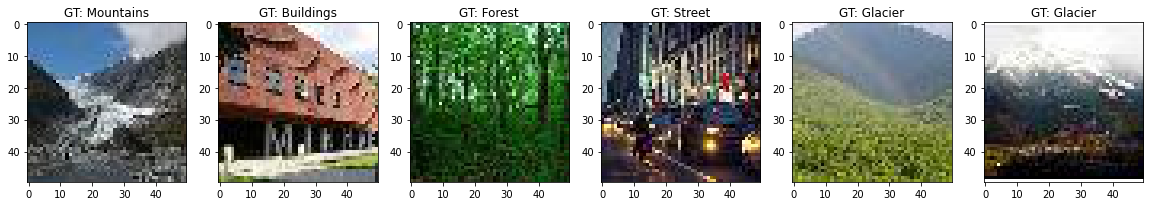

In [29]:
# get some random training images
dataiter = iter(val_loader)
images, labels = next(dataiter)

show_images(images[:6], labels[:6])


## Step 2: Define the Network

After we've set up the data, we now need to define the network we will use to perform image classification.

To do so, we need to create a PyTorch network.
To define your own PyTorch network, you need to subclass the `torch.nn.Module` class and implement two functions:

1. `__init__`: Initialize the network, defining all the layers in the network to use.
2. `forward`: Defines the forward pass of the network, which takes an image as input and outputs classification scores for each class.

As you will notice, we only have to define the forward pass of the network but not the backward pass (backpropagation). This is because PyTorch handles computing gradients for each operation for you ([autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)), so you don't have to worry about it at all!

We've implemented a very simple CNN for you already in `cnn_network.py` with a single convolutional layer, pooling layer, and fully-connected layer. You can run this cell to see the network architecture as well as test the forward pass of the network.

**Important:** Don't forget to import the `cnn_network.py` file every time you modify it, otherwise your latest changes won't be loaded.

In [17]:
from cnn_network import CNN

cnn_network = CNN()  # create CNN model

print("CNN Architecture:")
print(cnn_network)

print("")
print("Testing network input / output.")
test_input = torch.zeros(1, 3, 50, 50)  # batch size X 3 (RGB) X width X height
print(f"Input shape: {test_input.shape}")
test_output = cnn_network(test_input)  # batch size X # classes
print(f"Output shape: {test_output.shape}")

assert tuple(test_output.shape) == (1, 6), "Output shape should be [1, 6]"

CNN Architecture:
CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=150, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=6, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
)

Testing network input / output.
Input shape: torch.Size([1, 3, 50, 50])
Output shape: torch.Size([1, 6])


## Step 3: Define the cost function and the optimizer

Next we define the cost function and the optimizer to be used for training. 

For the image classification task, the most commonly use loss function is the Cross-Entropy loss, which we will use here. However, feel free to play around with other losses you can think of. 

We will use the Stochastic-Gradient descent optimizer. The optimizer contains two hyperparameters, namely the learning rate and the momentum. You are free to test other optimizers. Note that PyTorch gives implementations of commonly used optimizers such as SGD, Adam, etc.

Please check the `cnn_network.py` file to see how these components are defined.

In [18]:
from cnn_network import get_loss_function, get_optimizer

# criterion = get_loss_function()  # get loss function
optimizer = get_optimizer(cnn_network, lr=0.001, momentum=0.9)  # get optimizer

## Step 4: Train the Network

Now that we've defined both the data and the network, it's time to train our network on the data.

To do so, we simply just iterate over each batch of data, compute the network loss, then optimize the network parameters with backpropagation. See the code below for details on the right way to do this in PyTorch.

Run this cell to train the network.
This may take some time.
You should see the training loss go down in the initial iterations then plateau.

**Note:** We reinitialize the network, and load dataset, optimizer, loss function etc again here so that it is convenient to modify them in a single place.

In [43]:
from cnn_network import get_transforms_val, get_transforms_train, CNN, get_loss_function, get_optimizer
import torch.nn.functional as F
# *********************************************************** #
# set all training parameters. You can play around with these
# *********************************************************** #

batch_size = 48           # Number of images in each batch
learning_rate = 0.001    # Learning rate in the optimizer
momentum = 0.9           # Momentum in SGD
num_epochs = 30           # Number of passes over the entire dataset
print_every_iters = 100  # Print training loss every X mini-batches


# *********************************************************** #
# Initialize all the training components, e.g. model, cost function
# *********************************************************** #

# Get transforms
transform_train = get_transforms_train()
transform_val = get_transforms_val()

# Generate our data loaders
train_loader, val_loader, test_loader = get_dataloaders(batch_size, transform_train, transform_val)

# create CNN model
cnn_network = CNN()  

# Get optimizer and loss functions
# criterion = get_loss_function() 
optimizer = get_optimizer(cnn_network, lr=learning_rate, momentum=momentum) 



# *********************************************************** #
# The main training loop. You dont need to change this
# *********************************************************** #
training_loss_per_epoch = []
val_loss_per_epoch = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # First we loop over training dataset
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()  # zero the gradients from previous iteration

        # forward + backward + optimize
        outputs = cnn_network(inputs)  # forward pass to obtain network outputs
        loss = F.nll_loss(F.log_softmax(outputs, dim=1), labels, reduction='mean')  # compute loss with respect to labels
        loss.backward()  # compute gradients with backpropagation (autograd)
        optimizer.step()  # optimize network parameters

        # print statistics
        running_loss += loss.item()
        if (i + 1) % print_every_iters == 0:
            print(
                f'[Epoch: {epoch + 1} / {num_epochs},'
                f' Iter: {i + 1:5d} / {len(train_loader)}]'
                f' Training loss: {running_loss / (i + 1):.3f}'
            )
    
    mean_loss = running_loss / len(train_loader)
    training_loss_per_epoch.append(mean_loss)

    # # Next we loop over validation dataset
    # running_loss = 0.0
    # for i, data in enumerate(val_loader, 0):
    #     # get the inputs; data is a list of [inputs, labels]
    #     inputs, labels = data

    #     # on validation dataset, we only do forward, without computing gradients
    #     with torch.no_grad():
    #         outputs = F.softmax(cnn_network(inputs), dim=1) # forward pass to obtain network outputs
    #         # for _ in range(100):
    #         #     outputs += F.softmax(cnn_network(inputs), dim=1)
    #         # outputs = outputs/101
    #         loss = F.nll_loss(F.log_softmax(outputs, dim=1), labels, reduction='mean')  # compute loss with respect to labels
        
    #     # print statistics
    #     running_loss += loss.item()

    # mean_loss = running_loss / len(val_loader)
    # val_loss_per_epoch.append(mean_loss)

    # print(
    #     f'[Epoch: {epoch + 1} / {num_epochs}]'
    #     f' Validation loss: {mean_loss:.3f}'
    # )

# print('Finished Training')

# # Plot the training curves
# plt.figure()
# plt.plot(np.array(training_loss_per_epoch))
# plt.plot(np.array(val_loss_per_epoch))
# plt.legend(['Training loss', 'Val loss'])
# plt.xlabel('Epoch')
# plt.show()
# plt.close()

[Epoch: 1 / 30, Iter:   100 / 125] Training loss: 1.554
[Epoch: 2 / 30, Iter:   100 / 125] Training loss: 1.149
[Epoch: 3 / 30, Iter:   100 / 125] Training loss: 1.057
[Epoch: 4 / 30, Iter:   100 / 125] Training loss: 1.000
[Epoch: 5 / 30, Iter:   100 / 125] Training loss: 0.950
[Epoch: 6 / 30, Iter:   100 / 125] Training loss: 0.958
[Epoch: 7 / 30, Iter:   100 / 125] Training loss: 0.896
[Epoch: 8 / 30, Iter:   100 / 125] Training loss: 0.845
[Epoch: 9 / 30, Iter:   100 / 125] Training loss: 0.859
[Epoch: 10 / 30, Iter:   100 / 125] Training loss: 0.816
[Epoch: 11 / 30, Iter:   100 / 125] Training loss: 0.818
[Epoch: 12 / 30, Iter:   100 / 125] Training loss: 0.819
[Epoch: 13 / 30, Iter:   100 / 125] Training loss: 0.791
[Epoch: 14 / 30, Iter:   100 / 125] Training loss: 0.794
[Epoch: 15 / 30, Iter:   100 / 125] Training loss: 0.779
[Epoch: 16 / 30, Iter:   100 / 125] Training loss: 0.770
[Epoch: 17 / 30, Iter:   100 / 125] Training loss: 0.755
[Epoch: 18 / 30, Iter:   100 / 125] Trai

## Step 5: Test the Network

After training the network, it is time to test our network on the validation set, which includes images not seen during training. This will tell us how well the network can perform on new data.

We first visualize several network predictions on validation samples along with the ground truth labels.
You can run this cell multiple times to visualize different images.

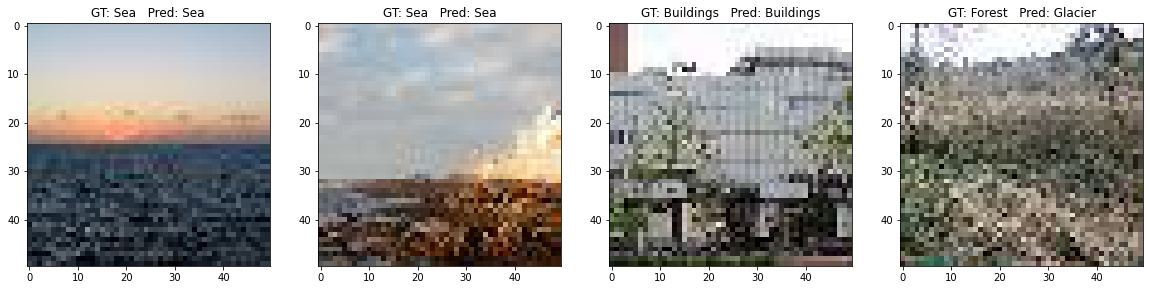

In [44]:
# get a few validation samples
images, labels = next(iter(val_loader))

# get network output
# outputs = cnn_network(images)  # classification scores
outputs = F.softmax(cnn_network(images), dim =1)
for _ in range(100):
    outputs += F.softmax(cnn_network(images), dim=1)
outputs = outputs/101
_, predicted = torch.max(outputs, 1)  # use maximum as prediction label

# visualize ground truth and predictions
show_images(images[:4], labels[:4], predicted[:4])

To get the full picture of the network performance, we need to evaluate on the full validation set.
This cell will iterate over every validation image, obtain the network prediction, and compare with the corresponding ground truth.
The evaluation score is the percentage of labels predicted correctly.
This may take some time.
You should see an accuracy of around 63%.

In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = F.softmax(cnn_network(images), dim =1)
        for _ in range(100):
            outputs += F.softmax(cnn_network(images), dim=1)
        outputs = outputs/101
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 50 == 0:
            print(f'Validation [{i + 1:5d} / {len(val_loader)}]')

print(f'Accuracy of the network on the 1500 validation images: {100 * correct / total:.2f} %')

Accuracy of the network on the 1500 validation images: 73.25 %


## Your Turn

**TODO:** We provided a simple CNN and boilerplate training code to introduce PyTorch to you.
These are written in their simplest form to leave ample room for extension.
Your task is to improve the network's performance on the test set.

**Note:** You are not allowed to use any external packages except the ones already imported in `cnn_network.py`. Otherwise your submission will crash on the Evaluation server.


**Hints:** Things that can potentially improve test accuracy:
- Deeper architecture: Adding more layers can lead to better performance, but be careful of overfitting to the training set!
- Activation functions: Introducing activation functions can increase the capacity of the network.
- Training parameters: Modifying the length of training, learning rate, optimizer, loss function, etc. can all improve network performance, but again be careful of overfitting!
- Transforms: Adding data transforms essentially generates more data for training, which helps alleviate overfitting. See full list of available transforms [here](https://pytorch.org/vision/stable/transforms.html).

## Generate the final submission on the test set

When you are happy with your network, you can run the next cell to generate your network predictions on the test set, which will be stored in the submission directory on your Google Drive.
Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server at https://codalab.lisn.upsaclay.fr/competitions/8751 to obtain the scores on the test set.

In [23]:
predictions = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images = data
        # calculate outputs by running images through the network
        outputs = F.softmax(cnn_network(images), dim =1)
        for _ in range(100):
            outputs += F.softmax(cnn_network(images), dim=1)
        outputs = outputs/101
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted.item())

        if (i + 1) % 100 == 0:
            print(f'Test [{i + 1:5d} / {len(test_loader)}]')

print("Writing predictions to file..")
test_imgs = []
with open(f"{env_path}/data/test.csv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for i, line in enumerate(reader):
        test_imgs.append(line[0])

out_dir = f'{env_path}/submission'
os.makedirs(out_dir, exist_ok=True)
with open(f'{out_dir}/test.csv', 'w') as fp:
    writer = csv.writer(fp)
    for test_img, pred in zip(test_imgs, predictions):
        writer.writerow([test_img, str(pred)])
shutil.copyfile(f'{env_path}/cnn_network.py', f'{out_dir}/cnn_network.py')
print("Done. You can submit now.")

Test [  100 / 1200]
Test [  200 / 1200]
Test [  300 / 1200]
Test [  400 / 1200]
Test [  500 / 1200]
Test [  600 / 1200]
Test [  700 / 1200]
Test [  800 / 1200]
Test [  900 / 1200]
Test [ 1000 / 1200]
Test [ 1100 / 1200]
Test [ 1200 / 1200]
Writing predictions to file..
Done. You can submit now.
